# NOTE: Is not up to date. TBD

# Learning and optimizing over directions

This notebook provides some examples on generating and working with directions 
in our package. 
We provide a conceptual overview on how directions are generated and how one might
go about learning a particular set of directions for a given problem.

In [64]:
%load_ext autoreload
%autoreload 2

import torch 
from torch import nn
from torch_geometric. data import Data, Batch
import matplotlib.pyplot as plt


from dect.directions import generate_2d_directions
from dect.nn import ECTLayer, ECTConfig

# Set up hardware configurations
DEVICE = "cuda:0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The direction vectors are always in the format `[ndims,num_thetas]` where
`ndims` is the dimension of the ambient space and `num_thetas` is the number of
directions used. Optionally if one is interested in multiple sets of directions 
we can provide the directions as a vector of size `[num_channels,ndims,num_thetas]`
in which case we will returned a set of images with each channel corresponding to 
an ECT with those directions. An example of that use case is shown at the end 
of this notebook.

In [65]:
# Generate 128 uniformly spaced directions in two dimensions.
num_thetas = 128
v = torch.vstack(
        [
            torch.sin(torch.linspace(0, torch.pi, num_thetas)),
            torch.cos(torch.linspace(0, torch.pi, num_thetas)),
        ]
    )

# Output shape
print(v.shape)


torch.Size([2, 128])


# Learning Directions

Now we wish to learn the direction (the uniform angles) that generated the ECT
in the previous example.

In order to do so, we initialize all the directions in one spot and make them
learnable. For a loss function we use the MSE between the groundtruth and
approximation. 

In [66]:
# Basic dataset with three points.
points_coordinates = torch.tensor([[0.3, 0.0], [0.7, 0.0]])
point_cloud = Data(x=points_coordinates)

batch = Batch.from_data_list([point_cloud])

# Initialize the ground truth layer
fixed_layer = ECTLayer(
    ECTConfig(
        ect_type="points", # The type of ect
        resolution=32, # Number of discretization steps
        scale=8,
        radius=1.0, # Radius of the ECT 
        normalized=False, # Whether to scale the ECT to the interval [0,1] 
        fixed=True # Learnable or fixed directions.
        ),
    v=generate_2d_directions(num_thetas=32)
)


# Generate all directions at the same spot at (0,1).
num_thetas = 32
v = torch.vstack(
        [
            torch.zeros_like(torch.linspace(0, 2*torch.pi, num_thetas)),
            torch.ones_like(torch.linspace(0, 2*torch.pi, num_thetas)),
        ]
    )


# Initialize the learnable layer
learnable_layer = ECTLayer(
    ECTConfig(
        ect_type="points", # The type of ect
        resolution=32, # Number of discretization steps
        scale=8,
        radius=1.0, # Radius of the ECT 
        normalized=False, # Whether to scale the ECT to the interval [0,1] 
        fixed=False # Learnable or fixed directions.
        ),
    v=v
)



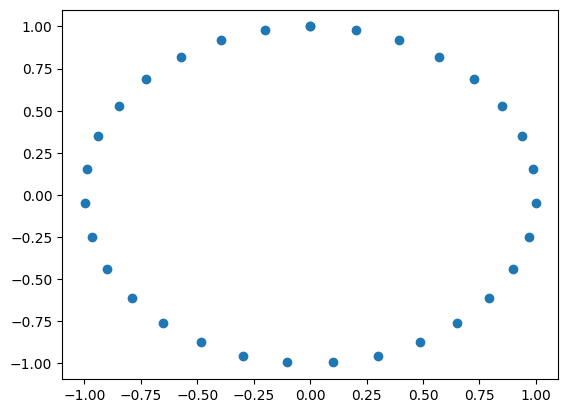

In [67]:
fixedv = fixed_layer.v.numpy()
plt.scatter(fixedv[:,0],fixedv[:,1])

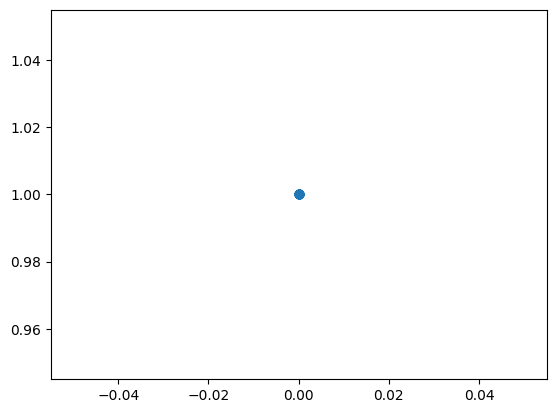

In [68]:
learnablev = learnable_layer.v.detach().numpy()
plt.scatter(learnablev[:,0],learnablev[:,1])

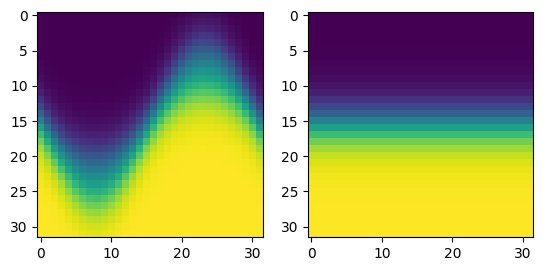

In [69]:
# Compute the ECT and plot
ect_groundtruth = fixed_layer(batch)
ect = learnable_layer(batch)

fig, axes = plt.subplots(1,2)

ax = axes[0]
ax.imshow(ect_groundtruth.squeeze().detach().cpu().numpy())

ax = axes[1]
ax.imshow(ect.squeeze().detach().cpu().numpy())


Now we can start optimizing using pytorch.

In [70]:
optimizer = torch.optim.Adam(learnable_layer.parameters(),lr=0.01)
loss_fn = nn.MSELoss()


for epoch in range(500):
    optimizer.zero_grad()
    ect_pred = learnable_layer(batch)    
    loss = loss_fn(ect_pred, ect_groundtruth)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0: 
        print(f"Epoch: {epoch}, Loss: {loss.item():.2f}")




Epoch: 0, Loss: 0.24
Epoch: 50, Loss: 0.06
Epoch: 100, Loss: 0.01
Epoch: 150, Loss: 0.00
Epoch: 200, Loss: 0.00
Epoch: 250, Loss: 0.00
Epoch: 300, Loss: 0.00
Epoch: 350, Loss: 0.00
Epoch: 400, Loss: 0.00
Epoch: 450, Loss: 0.00


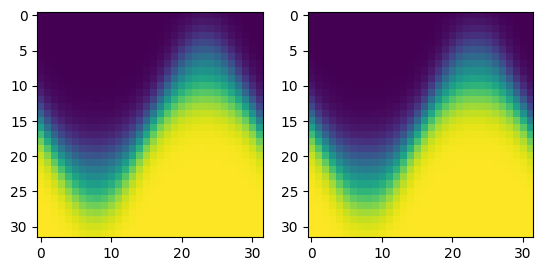

In [71]:
# Compute the ECT and plot
ect_groundtruth = fixed_layer(batch)
ect = learnable_layer(batch)

fig, axes = plt.subplots(1,2)

ax = axes[0]
ax.imshow(ect_groundtruth.squeeze().detach().cpu().numpy())

ax = axes[1]
ax.imshow(ect.squeeze().detach().cpu().numpy())